In [2]:
import os
setup_script = os.path.join(os.environ['ENV_JUPYTER_SETUPS_DIR'], 'setup_sci_env_basic.py')
%run $setup_script

In [3]:
from scipy.stats import norm
from scipy.stats import poisson
from scipy.optimize import minimize

In [55]:
def likelihood_poi(mu, n, bkg, s0=1.0, neg=False, log=False):
    """Return the value of the Poisson likelihood function, given the:
       - mu: signal strength parameter,
       - n: number of events observed,
       - bkg: expected number of background events,
       - s0: nominal number of signal events
       The total expected number of events is lambda = bkg + mu*s0.
       
       The `neg` argument just multiplies the likelihood by (-1).
       This is used to for the minimize() function."""
    sig = mu * s0
    exp = bkg + sig
    if log:
        likelihood = poisson.pmf(n, mu=exp)
    else:
        likelihood = poisson.logpmf(n, mu=exp)
    
    if neg:
        return -likelihood
    return likelihood

In [64]:
def model_likelihood(parameters, SR_measured, CR_measured, s0=1.0, log=False, neg=False):
    mu = parameters[0]
    NP_bkgr = parameters[1]
    if log:
        likelihood_SR = likelihood_poi(mu, SR_measured, NP_bkgr, log=True)
        likelihood_CR = poisson.logpmf(CR_measured, mu=NP_bkgr*CR_b_factor)
        model_likelihood = likelihood_SR+likelihood_CR
    else:
        likelihood_SR = likelihood_poi(mu, SR_measured, NP_bkgr, log=False)
        likelihood_CR = poisson.pmf(CR_measured, mu=NP_bkgr*CR_b_factor)
        model_likelihood = likelihood_SR*likelihood_CR
    if neg:
        return -model_likelihood
    else:
        return model_likelihood

In [5]:
b_H0 = 1000.0

In [19]:
nExperiments = 1000

In [20]:
Z = 1.64
s0 = 1.0

In [35]:
NP_bkgr_H0 = 1000.0

## Hypotheses

### Null hypothesis $H_{0}$

$H_{0}$ hypothesis parameters

SR

In [42]:
NP_bkgr_H0 = 1000.0
SR_b_H0 = NP_bkgr_H0*1.0             # - Number of background events
SR_s_H0 = 0.0
SR_pred_H0 = SR_b_H0 + SR_s_H0  # - s + b
mup_H0 = SR_s_H0/s0               # - mu^' (mu prime)

In [43]:
SR_events_H0 = poisson.rvs(mu=SR_pred_H0, loc=0.0, size=nExperiments)

CR

In [45]:
CR_b_factor = 5.0
CR_b_H0     = NP_bkgr_H0*CR_b_factor
CR_pred_H0  = CR_b_H0

In [46]:
CR_events_H0 = poisson.rvs(mu=CR_pred_H0, loc=0.0, size=nExperiments)

### Alternative hypothesis $H_{1}$

$H_{1}$ hypothesis parameters

SR

In [120]:
NP_bkgr_H1 = 1000.0
SR_b_H1 = NP_bkgr_H1*1.0             # - Number of background events
SR_s_H1 = 20.0
SR_pred_H1 = SR_b_H1 + SR_s_H1  # - s + b
mup_H1 = SR_s_H1/s0               # - mu^' (mu prime)

In [121]:
SR_events_H1 = poisson.rvs(mu=SR_pred_H1, loc=0.0, size=nExperiments)

In [122]:
CR_b_factor = 5.0
CR_b_H1     = NP_bkgr_H1*CR_b_factor
CR_pred_H1  = CR_b_H1

In [123]:
CR_events_H1 = poisson.rvs(mu=CR_pred_H1, loc=0.0, size=nExperiments)

----

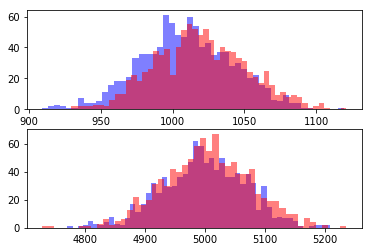

In [129]:
f,axes = plt.subplots(nrows=2)
a = axes.flatten()
a[0].hist(SR_events_H0, bins=50, color='b', alpha=0.5)
a[1].hist(CR_events_H0, bins=50, color='b', alpha=0.5);
a[0].hist(SR_events_H1, bins=50, color='r', alpha=0.5)
a[1].hist(CR_events_H1, bins=50, color='r', alpha=0.5);

In [65]:
model_likelihood([10.0, 1000.0], SR_events_H0, CR_events_H0)

array([-0.02362694, -0.00356784, -0.00603581, -0.02474822, -0.02503631,
       -0.01569926, -0.02277117, -0.02318331, -0.00753229, -0.0108622 ,
       -0.02285177, -0.01344375, -0.00054711, -0.01644125, -0.01588922,
       -0.01153687, -0.02513859, -0.01780751, -0.02550812, -0.01175296,
       -0.00801418, -0.02750288, -0.00418142, -0.01845212, -0.02356144,
       -0.02348075, -0.01192937, -0.00576062, -0.00734973, -0.01490309,
       -0.0238248 , -0.02554053, -0.02581127, -0.00784628, -0.02486977,
       -0.02918831, -0.02109917, -0.01605254, -0.02501108, -0.01616778,
       -0.02459217, -0.03245617, -0.02160328, -0.01617814, -0.02830594,
       -0.03042565, -0.01569637, -0.02581046, -0.02500644, -0.03180738,
       -0.0087565 , -0.02168247, -0.01808457, -0.0155274 , -0.03558168,
       -0.02643019, -0.01769676, -0.02293496, -0.01838468, -0.00834768,
       -0.02479235, -0.02814182, -0.00861997, -0.01264962, -0.02403461,
       -0.0319776 , -0.01489883, -0.01379087, -0.01429685, -0.02

In [93]:
def calc_parameter_MLE(NLL, SR, CR):
    res = minimize(NLL, x0=[1.0, 1000.0], args=(SR, CR, 1.0, True, True), method='Nelder-Mead')
    LL  = -res['fun']
    parameter_MLE = res['x']
    return parameter_MLE

In [125]:
parameters_H0 = [calc_parameter_MLE(model_likelihood, SR, CR) for SR, CR in zip(SR_events_H0, CR_events_H0)]
parameters_H1 = [calc_parameter_MLE(model_likelihood, SR, CR) for SR, CR in zip(SR_events_H1, CR_events_H1)]

In [127]:
parameters_H0 = np.array(parameters_H0)
parameters_H1 = np.array(parameters_H1)

Text(0,0.5,'$\\hat{NP}_{bkgr}$')

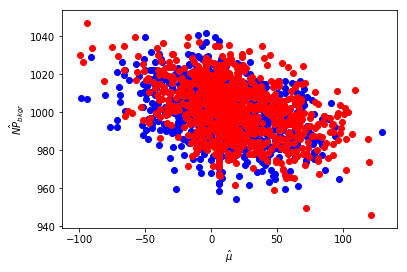

In [128]:
f,a = plt.subplots()
a.scatter(parameters_H0[:,0], parameters_H0[:,1], c='b')
a.scatter(parameters_H1[:,0], parameters_H1[:,1], c='r')
a.set_xlabel(r'$\hat{\mu}$')
a.set_ylabel(r'$\hat{NP}_{bkgr}$')